In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy import stats
import random
import os
import tensorflow as tf
import math
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
import string
import os

In [2]:
SIZE = 500

seed = 505
img_size = 256
img_path = 'kaggle_dataset/dataset_1_images/dataset_1_images/Food Images/'


In [3]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    

In [4]:
def image_mapping_check(dataset):
    counter = 0
    record = []
    while counter < dataset.shape[0]-1:
        row = dataset.loc[counter]
        img_name = row['Image_Name']
        img = cv2.imread(img_path+img_name+'.jpg')
        try:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 
        except:
            record.append(counter)
        counter += 1
    new = dataset.drop(record, axis = 0)
    new = new.reset_index(drop = True)
    return new

In [5]:
path = ['kaggle_dataset/cleaned_dataset_1.csv', 'kaggle_dataset/ingredients_modified.csv']
df = [pd.read_csv(path[0]), pd.read_csv(path[1])]
df[0]['cleaned'] = df[1]['cleaned']
df[0]['Instructions'] = df[1]['Instructions']
df[0]['Title'] = df[1]['Title']
df = df[0]
df = df[df.Title.notna()]

In [6]:
df = image_mapping_check(df)

In [7]:
df.isnull().sum()

Title                  0
Instructions           0
Image_Name             0
Cleaned_Ingredients    0
dataset                0
id                     0
cleaned                0
dtype: int64

In [8]:
df[df['cleaned'].isna()]

,Title,Instructions,Image_Name,Cleaned_Ingredients,dataset,id,cleaned


In [9]:
df[df.cleaned.str.len() == 1]

,Title,Instructions,Image_Name,Cleaned_Ingredients,dataset,id,cleaned


In [10]:
min([len(i) for i in df.Title.str.split().tolist()]), max([len(i) for i in df.Title.str.split().tolist()])

(1, 19)

<AxesSubplot:>

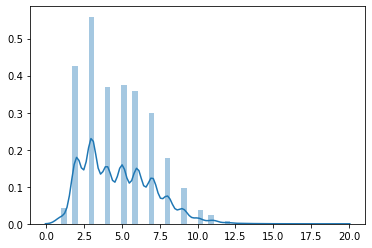

In [11]:
sns.distplot([len(i) for i in df.Title.str.split().tolist()])

In [12]:
title_words_to_index = {"PAD": 0}
title_index_to_words = ["PAD"]
TITLE_MAX_LEN = 5

skip_words = {"in", "and", "the", 'a', 'y', 'w', 'law'}


def title_book_keeping(titles):
    titles = titles.str.split().tolist()
    for i in titles:
        for j in i:
            j = j.lower()
            if all([j not in skip_words, not j.isdigit(), all([x not in string.punctuation for x in j])]):
                
                if j not in title_words_to_index:
                    title_index_to_words.append(j)
                    title_words_to_index[j] = len(title_index_to_words) - 1
title_book_keeping(df.Title)
pickle.dump(title_index_to_words, open('kaggle_dataset/title_index_to_words.pkl', 'wb'))

pickle.dump(title_words_to_index, open('kaggle_dataset/title_words_to_index.pkl', 'wb'))

In [13]:
len(title_index_to_words), len(title_words_to_index)

(4304, 4304)

In [14]:
embeddings_index = {}
f = open('glove.6B.50d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

embedding_dim = 50
vocab_size = len(title_index_to_words)
embedding_matrix = np.zeros((vocab_size, embedding_dim))
default_vector = np.zeros(50, dtype=np.float64)
for word, i in title_words_to_index.items():
    embedding_matrix[i] = embeddings_index.get(word, default_vector)
    
    

In [15]:
title_index_to_words

['PAD',
 'roast',
 'chicken',
 'with',
 'acorn',
 'squash',
 'panzanella',
 'crispy',
 'salt',
 'pepper',
 'potatoes',
 'thanksgiving',
 'mac',
 'cheese',
 'italian',
 'sausage',
 'bread',
 'stuffing',
 'warm',
 'comfort',
 'apples',
 'oranges',
 'turmeric',
 'hot',
 'toddy',
 'instant',
 'pot',
 'lamb',
 'haleem',
 'spiced',
 'lentil',
 'caramelized',
 'onion',
 'baked',
 'eggs',
 'pimento',
 'dip',
 'spiral',
 'ham',
 'slow',
 'cooker',
 'butternut',
 'apple',
 'soup',
 'caesar',
 'salad',
 'rice',
 'leeks',
 'salsa',
 'verde',
 'gorditas',
 'con',
 'camarones',
 'enfrijoladas',
 'plantain',
 'parfait',
 'potato',
 'gratin',
 'brown',
 'butter',
 'cream',
 'roasted',
 'beets',
 'sunchokes',
 'pickled',
 'purée',
 'kale',
 'pumpkin',
 'falafels',
 'carrot',
 'slaw',
 'maple',
 'chile',
 'quinoa',
 'tabouli',
 'chhena',
 'poda',
 'paneer',
 'sloppy',
 'joe',
 'shirred',
 'spinach',
 'onions',
 'ramen',
 'spicy',
 'coconut',
 'baigan',
 'chokha',
 'dad’s',
 'curried',
 'trinidad',
 'cur

In [16]:
count_set = {}
count_length = {}
words_to_index = {"PAD": 0}
index_to_words = ["PAD"]
def get_masked_tokens(ings):
    all_ings = ings.str.split(',')
    
    for i in all_ings:
        for j in i:
            if j not in count_set:
                count_set[j] = 0
            count_set[j] += 1
    for i in all_ings:
        l = len(i)
        if l not in count_length:
            count_length[l] = 0
        count_length[l] += 1
    
    for i in all_ings:
        for j in i:
            if j not in words_to_index:
                index_to_words.append(j)
                words_to_index[j] = len(index_to_words) - 1
get_masked_tokens(df.cleaned)
pickle.dump(index_to_words, open("kaggle_dataset/index_to_words.pkl", 'wb'))

pickle.dump(words_to_index, open("kaggle_dataset/words_to_index.pkl", 'wb'))
max(count_set.values()), min(count_set.values())

(6403, 1)

In [17]:
max(count_length.keys())

47

<AxesSubplot:>

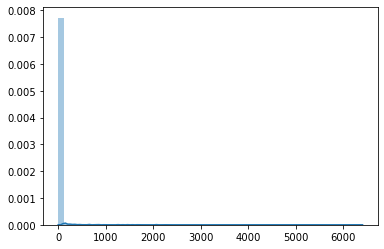

In [18]:
sns.distplot(list(count_set.values()))

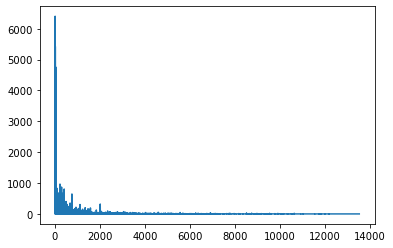

In [19]:
plt.plot(list(count_set.values()))

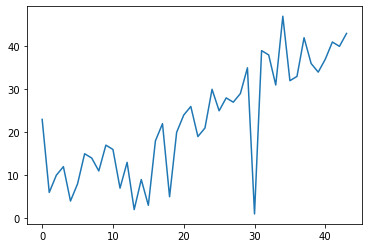

In [20]:
plt.plot(list(count_length.keys()))

<AxesSubplot:>

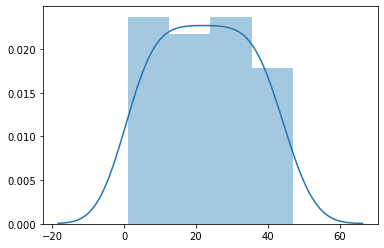

In [21]:
sns.distplot(list(count_length.keys()))

In [22]:
len(index_to_words)

13528

In [23]:
def get_dataset(df):
    
    x_train, x_val, y_train, y_val = train_test_split(df.loc[:, df.columns != 'cleaned'], df['cleaned'], shuffle = True, random_state = seed, test_size = 0.25)
    train_df = pd.concat([x_train, y_train], axis = 1).reset_index(drop = True)
    val_df = pd.concat([x_val, y_val], axis = 1).reset_index(drop = True)
    return df, train_df, val_df

In [24]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    
    if type(value) == str:
        
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[str.encode(value)]))
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def get_label(ing):
    all_ings = ing.split(',')
    ret = [0] * len(index_to_words)
    for idx, i in enumerate(all_ings):
        word_id = words_to_index[i]
#         assert not ret[word_id]
        ret[word_id] = 1
    return _int64_feature(ret)

def get_titles(t):
    t = t.split()
    
    idx = 0
    for j in t:
        j = j.lower()
        default_vector = np.zeros(50, dtype=np.float64)
        ret = embedding_matrix[title_words_to_index.get(j, 0)]
    return _float64_feature(ret)
        

def _float64_feature(value):
    # value is a list of integers
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _int64_feature(value):
    # value is a list of integers
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def serialize_example(img_name, img, cleaned, orig_ingredients, title, instructions):
    feature = {
        'image_name': _bytes_feature(img_name),
        'image': _bytes_feature(img),
        'cleaned_ingredients': get_label(cleaned),
        'orig_ingredients': _bytes_feature(orig_ingredients),
        'title': get_titles(title),
        'instructions': _bytes_feature(instructions)
        
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [25]:
def create_recored(dataset, title):
    CT = dataset.shape[0]//SIZE + int(dataset.shape[0]%SIZE!=0)
    for j in range(CT):
        print(); print('Writing TFRecord %i of %i...'%(j,CT))
        CT2 = min(SIZE,dataset.shape[0]-j*SIZE)
        if title == "train":
            with tf.io.TFRecordWriter('tfrecs/train%.4i-%.2i-%i.tfrec'%(seed,j,CT2)) as writer:
                for k in range(CT2):
                    counter = j*SIZE+k
                    row = dataset.loc[counter]
                    img_name = row['Image_Name']
                    img = cv2.imread(img_path+img_name+'.jpg')
                    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # Fix incorrect colors
                    img = cv2.resize(img,(img_size,img_size),interpolation = cv2.INTER_AREA)
                    img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 94))[1].tostring()
                    example = serialize_example(
                        str.encode(img_name),
                        img,
                        row['cleaned'],
                        row['Cleaned_Ingredients'],
                        row['Title'],
                        row['Instructions']
                    )
                    writer.write(example)
                    if k%100==0: print(k,', ',end='')
        else:
             with tf.io.TFRecordWriter('tfrecs/val%.4i-%.2i-%i.tfrec'%(seed,j,CT2)) as writer:
                for k in range(CT2):
                    counter = j*SIZE+k
                    img_name = dataset.Image_Name[counter]
                    img = cv2.imread(img_path+img_name+'.jpg')
                    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # Fix incorrect colors
                    img = cv2.resize(img,(img_size,img_size),interpolation = cv2.INTER_AREA)
                    img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 94))[1].tostring()
                    row = dataset.loc[counter]
                    example = serialize_example(
                        str.encode(img_name),
                        img,
                        row['cleaned'],
                        row['Cleaned_Ingredients'],
                        row['Title'],
                        row['Instructions']
                    )
                    writer.write(example)
                    if k%100==0: print(k,', ',end='')

In [26]:
def get_record(df, seed):
    seed_everything(seed)
    df, train_df, val_df = get_dataset(df)
    # save df
    df.to_csv('food_ingredients_dataset.csv', index = False)
    create_recored(train_df,title = "train")
    create_recored(val_df, title = "val")

In [27]:
get_record(df, seed)


Writing TFRecord 0 of 21...
0 , 

/home/ashutosh/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  from ipykernel import kernelapp as app


100 , 200 , 300 , 400 , 
Writing TFRecord 1 of 21...
0 , 100 , 200 , 300 , 400 , 
Writing TFRecord 2 of 21...
0 , 100 , 200 , 300 , 400 , 
Writing TFRecord 3 of 21...
0 , 100 , 200 , 300 , 400 , 
Writing TFRecord 4 of 21...
0 , 100 , 200 , 300 , 400 , 
Writing TFRecord 5 of 21...
0 , 100 , 200 , 300 , 400 , 
Writing TFRecord 6 of 21...
0 , 100 , 200 , 300 , 400 , 
Writing TFRecord 7 of 21...
0 , 100 , 200 , 300 , 400 , 
Writing TFRecord 8 of 21...
0 , 100 , 200 , 300 , 400 , 
Writing TFRecord 9 of 21...
0 , 100 , 200 , 300 , 400 , 
Writing TFRecord 10 of 21...
0 , 100 , 200 , 300 , 400 , 
Writing TFRecord 11 of 21...
0 , 100 , 200 , 300 , 400 , 
Writing TFRecord 12 of 21...
0 , 100 , 200 , 300 , 400 , 
Writing TFRecord 13 of 21...
0 , 100 , 200 , 300 , 400 , 
Writing TFRecord 14 of 21...
0 , 100 , 200 , 300 , 400 , 
Writing TFRecord 15 of 21...
0 , 100 , 200 , 300 , 400 , 
Writing TFRecord 16 of 21...
0 , 100 , 200 , 300 , 400 , 
Writing TFRecord 17 of 21...
0 , 100 , 200 , 300 , 400 ,

/home/ashutosh/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


100 , 200 , 300 , 400 , 
Writing TFRecord 1 of 7...
0 , 100 , 200 , 300 , 400 , 
Writing TFRecord 2 of 7...
0 , 100 , 200 , 300 , 400 , 
Writing TFRecord 3 of 7...
0 , 100 , 200 , 300 , 400 , 
Writing TFRecord 4 of 7...
0 , 100 , 200 , 300 , 400 , 
Writing TFRecord 5 of 7...
0 , 100 , 200 , 300 , 400 , 
Writing TFRecord 6 of 7...
0 , 100 , 200 , 300 , 

In [28]:
df.isna().sum()

Title                  0
Instructions           0
Image_Name             0
Cleaned_Ingredients    0
dataset                0
id                     0
cleaned                0
dtype: int64